In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


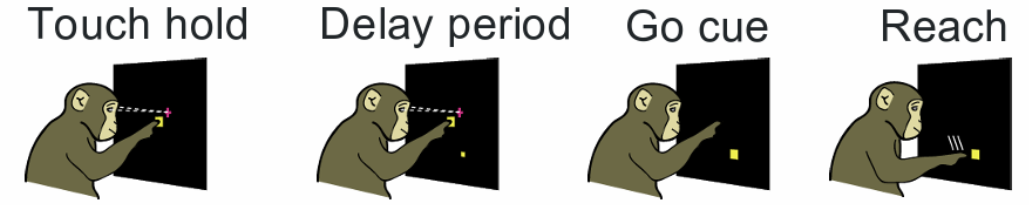

In [3]:
with open('datos_disparos_mono_tp2.npz', 'rb') as loadfile:
    spike_times = np.load(loadfile, allow_pickle=True)['spike_times'] #shape = 1127 episodios, 190 neuronas, nro de disparos (variable).
                                                                      #Recomendamos mirar len(spike_times), len(spike_times[n]), etc. para entender bien los datos

with open('metadata_mono_tp2.npy', 'rb') as loadfile:
    metadata = np.load(loadfile)
    time_touch_held = metadata['time_touch_held'] # tiempos de aparición del target para cada episodio
    time_go_cue = metadata['time_go_cue'] # tiempo de señal de GO (comienzo del movimiento) para cada episodio
    time_target_acquired = metadata['time_target_acquired'] # tiempo en que el objetivo fue tocado para cada episodio
    trial_reach_target = metadata['trial_reach_target'] # índice de a que target tenía que ir para cada episodio (0 a 7)
    target_locations = metadata['target_locations'] #  posición x,y de cada target
    target_angles = metadata['target_angles'] # ángulo de cada target


In [4]:
# Notar que hay dos duraciones de periodo de planificación
np.unique(time_go_cue - time_touch_held)

array([ 755, 1005])

In [5]:
def extract_plan_spikes(window_length=None,
                        start_offset=None):
    # Devuelve una matriz de conteos de disparos en la ventana de planificación
    # - La ventana de planificación default está definida como el tiempo
    #   entre time_touch_held y time_go_cue para cada episodio.
    #   NOTA: no todos los episodios tienen la misma duración!
    # - Si se especifica una "window_length" (longitud de ventana), devuelve el número
    #   de disparos en la ventana para esa duración. Retorna -1 si el periodo de planificación
    #   es demasiado corto para la ventana (ej. si window_length=1000 pero el periodo de
    #   planificación era 755ms)
    # - Si se especifica un "start_offset", retorna el número de disparos en la ventana
    #   que empieza "start_offset" ms después de time_touch_held (y usa time_go_cue o la
    #   window_length opcional para determinar el final de la ventana). Si start_offset
    #   es tan grande que se extiende más que time_go_cue, retorna -1

    if start_offset:
        trial_starts = time_touch_held + start_offset
    else:
        trial_starts = time_touch_held

    plan_spikes = []
    for tx, trialSpikes in enumerate(spike_times):#Para cada una de las neuronas (o más bien, para cada tren de disparo, que c/u pertenece a una neurona)
        if window_length:
            trial_end = trial_starts[tx] + window_length
        else:
            trial_end = time_go_cue[tx]

        if (trial_end < trial_starts[tx]) or (trial_end > time_go_cue[tx]):
            raise ValueError("El final del episodio (trial_end) es menor que el comienzo (trial_starts) o que el final del periodo de planificación (time_go_cue)")
                # plan_spikes.append(-np.ones(len(trialSpikes)))
        else:
            plan_spikes.append(#Sim
                np.array([np.sum((st > trial_starts[tx]) &
                        (st < trial_end)) for st in trialSpikes]))#Contamos cuantos disparos hubo en esa ventana!
    return np.array(plan_spikes) # debería ser de 1127 x 190 (nro de episodios x nro de neuronas)

In [6]:
#plan_spikes = extract_plan_spikes()
plan_spikes = extract_plan_spikes(window_length=750)

Separemos los episodios en set de entrenamiento y testeo

In [7]:
# selecciona los episodios con duración de periodo de planificación de 755 ms
short_trials = (time_go_cue - time_touch_held) == 755 # array booleano de longitud 1127 con todos los episodios de duración 755ms en 1 y el resto en 0

training_trials = [] # van a ser 8 listas de episodios (una para cada clase)
test_trials = [] # todos los que sobran
for c in range(8): # targets del 0 al 7
    #target_trials = np.argwhere(short_trials & (trial_reach_target==c)).squeeze()
    target_trials = np.argwhere((trial_reach_target==c)).squeeze()
    # seleccionar 25 episodios al azar (por cada dirección)
    random_training_trials = np.random.choice(target_trials, 25, replace=False)
    training_trials.append(random_training_trials)
    remaining_test_trials = np.setdiff1d(target_trials, random_training_trials)

    test_trials.extend(remaining_test_trials)


In [8]:
# Calcular el nro promedio de disparos por neurona y target
# Representa las medias de una distribución de Poisson 190-dimensional para cada una de las direcciones
num_neurons = plan_spikes.shape[1]
mean_spike_counts = np.zeros((num_neurons, 8)) # Notar que las dimensiones son 190 neuronas x 8 direcciones
for c in range(8):
    mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:], axis=0)


In [9]:
def multivariate_poisson_logpdf(mu, x, mean_eps=0.01):
    # asume mu es dimensión (N,) y x es (d,N)
    mu2 = mu
    mu2[np.argwhere(mu < mean_eps)] = mean_eps # setea un promedio de disparos muy bajitos para los que daban 0 para evitar que tenga probabilidad 0
    return np.sum(x * np.log(mu2) - mu2, axis=1)

In [10]:
# Calcula la probabilidad para cada target y cada episodio
poisson_likelihood = np.zeros((len(test_trials), 8))
for c in range(8):
    m = mean_spike_counts[:,c]
    poisson_likelihood[:,c] = \
        multivariate_poisson_logpdf(m, plan_spikes[test_trials,:])


# 1.a
Para ver como varia la presicion, decidi ejecutar 10 veces ambos y tomar la media. Para el caso 1 (sin modificaciones) hay 364 episodios de testeo elegidos al azar y la media de porcentaje correcto de presicion fue de: 92.77%. Luego efectuando los cambios mencionados en la consigna, se pasa a tener 927 episodios de testeo con una media de porcentaje correcto de presicion de:  92.30%. Se puede observar que el agregar casi un 150% de casos de testeo, `NO` llevo a un incremento en el porcentaje correcto de presicion.

In [11]:
correct_targets = trial_reach_target[test_trials] # target correcto para cada episodio
decoded_targets = np.argmax(poisson_likelihood,axis=1) # el target decodificado es el que nos dá la mayor verosimilitud!
print('Porcentaje correcto: ', np.mean(correct_targets==decoded_targets)) #NOTA acá menciona el Ej1a!
print('({} episodios de testeo)'.format(len(test_trials)))

Porcentaje correcto:  0.9158576051779935
(927 episodios de testeo)


# 1.b
En la salida se esperaban 15 items, por lo cual decidi dividir el segmento de 0 750 en 15 secciones, armando la lista con el siguiente codigo i e [0, 16).
```py
window_lengths = [(750/15)*i for i in range(1, 16)]
```
Luego usamos estas window_lengths individualmente para extraer los spikes
```py
plan_spikes = extract_plan_spikes(window_length=window_length) #seleccionar ventanas
```

In [12]:
decode_perf = []
qty_segments = 15
# divido el segmento en 15 partes hasta 750
window_lengths = [(750/qty_segments)*i for i in range(1, qty_segments+1)]
for window_length in window_lengths: #CAMBIEN ESTA LÍNEA EN BASE A LA VARIABLE POR LA CUAL QUIERAN IR ITERANDO!
    plan_spikes = extract_plan_spikes(window_length=window_length) #seleccionar ventanas
    decode_perf.append([])

    # Arma sets de entrenamiento y testeo 50 veces
    for i in range(50):
        # Armar seleccionar los sets de entrenamiento y testeo al azar
        training_trials = [] # será una lista de 8 listas de episodios
        test_trials = [] # todos los demás
        for c in range(8):
            target_trials = np.argwhere((trial_reach_target==c)).squeeze()
            # seleccionar 25 episodios al azar (por cada dirección)
            random_training_trials = np.random.choice(target_trials, 25, replace=False)
            training_trials.append(random_training_trials)
            remaining_test_trials = np.setdiff1d(target_trials, random_training_trials)

            test_trials.extend(remaining_test_trials)
        # Calcular los disparos medios (mean_spike_counts) usando los datos de entrenamiento
        num_neurons = plan_spikes.shape[1]
        mean_spike_counts = np.zeros((num_neurons, 8))
        for c in range(8):
            mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:], axis=0)
        # Calcular las verosimilitudes para cada target
        poisson_likelihood = np.zeros((len(test_trials), 8))
        for c in range(8):
            m = mean_spike_counts[:,c]
            poisson_likelihood[:,c] = \
                multivariate_poisson_logpdf(m, plan_spikes[test_trials,:])

        # Decodificar eligiendo cual es el objetivo más probable
        correct_targets = trial_reach_target[test_trials] # target correcto para cada episodio
        decoded_targets = np.argmax(poisson_likelihood,axis=1) # el target decodificado es el que nos dá la mayor verosimilitud!

        decode_perf[-1].append(np.mean(correct_targets==decoded_targets))

decode_perf = np.array(decode_perf) # convertir a numpy array

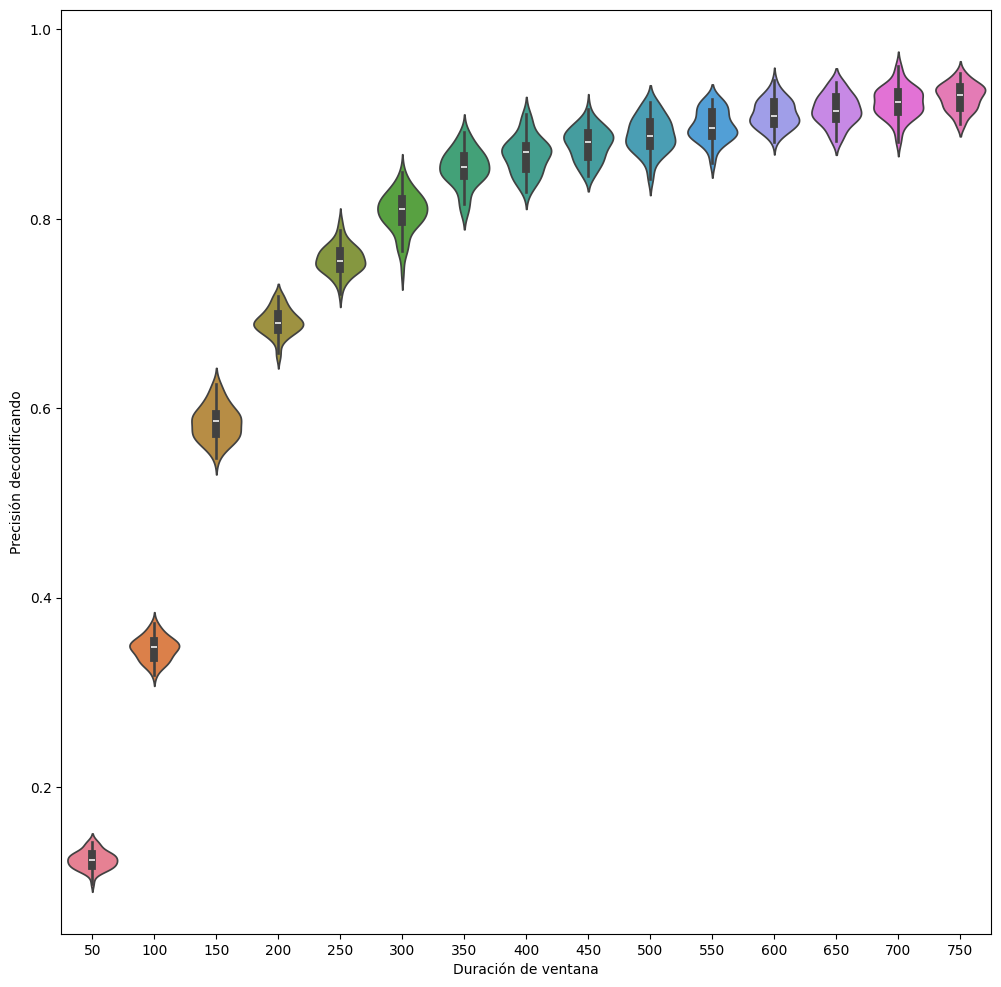

In [13]:
import pandas as pd
fig = plt.figure(figsize=(12,12))
ax = sns.violinplot(data=pd.DataFrame(decode_perf.T, columns=np.arange(50,800,50)))
#Para el que nunca haya visto Violinplots antes, son escencialmente histogramas que han sido suavizados y espejados para facilitar la visualización
ax.set(xlabel='Duración de ventana', ylabel='Precisión decodificando')
plt.show()


A medida que aumentamos la duracion de la ventana, se incrementa la precision de decodificado. Se puede apreciar que la mejora en precision empieza a estancar a partir de una duracion de ventana de 300 / 350.

# 1.c
Siguiendo la consigna aplique una ventana de 250ms. Dividi el segmento en 21 [0, 500] con saltos de 25, porque me di cuenta como editar la cantidad de segmentos en el grafico :D.

In [40]:
decode_perf = []
qty_segments = 20
offsets = [(500/qty_segments)*i for i in range(0, qty_segments+1)]
for offset in offsets: #CAMBIEN ESTA LÍNEA EN BASE A LA VARIABLE POR LA CUAL QUIERAN IR ITERANDO!
    plan_spikes = extract_plan_spikes(window_length=250, start_offset=offset) #seleccionar ventanas
    decode_perf.append([])

    # Arma sets de entrenamiento y testeo 50 veces
    for i in range(50):
        # Armar seleccionar los sets de entrenamiento y testeo al azar
        training_trials = [] # será una lista de 8 listas de episodios
        test_trials = [] # todos los demás
        for c in range(8):
            target_trials = np.argwhere((trial_reach_target==c)).squeeze()
            # seleccionar 25 episodios al azar (por cada dirección)
            random_training_trials = np.random.choice(target_trials, 25, replace=False)
            training_trials.append(random_training_trials)
            remaining_test_trials = np.setdiff1d(target_trials, random_training_trials)

            test_trials.extend(remaining_test_trials)
        # Calcular los disparos medios (mean_spike_counts) usando los datos de entrenamiento
        num_neurons = plan_spikes.shape[1]
        mean_spike_counts = np.zeros((num_neurons, 8))
        for c in range(8):
            mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:], axis=0)
        # Calcular las verosimilitudes para cada target
        poisson_likelihood = np.zeros((len(test_trials), 8))
        for c in range(8):
            m = mean_spike_counts[:,c]
            poisson_likelihood[:,c] = \
                multivariate_poisson_logpdf(m, plan_spikes[test_trials,:])

        # Decodificar eligiendo cual es el objetivo más probable
        correct_targets = trial_reach_target[test_trials] # target correcto para cada episodio
        decoded_targets = np.argmax(poisson_likelihood,axis=1) # el target decodificado es el que nos dá la mayor verosimilitud!

        decode_perf[-1].append(np.mean(correct_targets==decoded_targets))

decode_perf = np.array(decode_perf) # convertir a numpy array

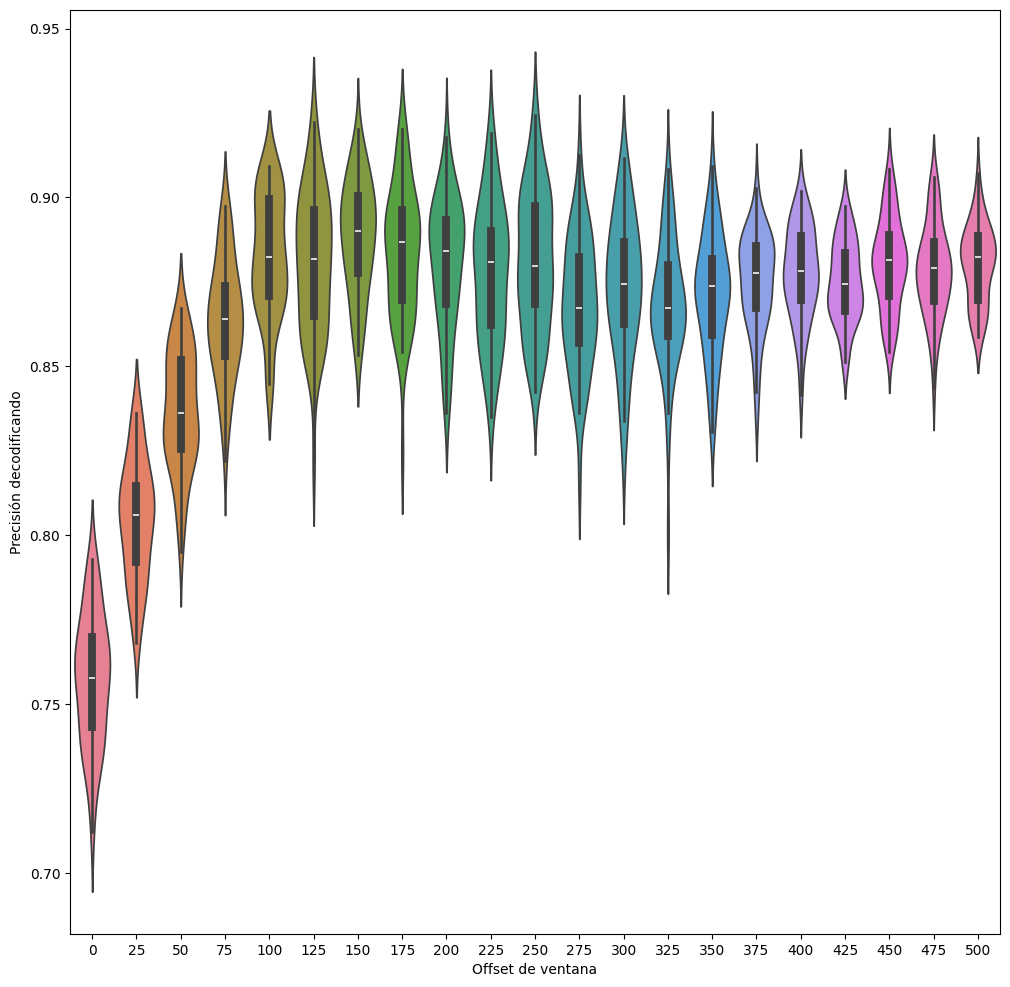

In [41]:
import pandas as pd
fig = plt.figure(figsize=(12,12))
ax = sns.violinplot(data=pd.DataFrame(decode_perf.T, columns=np.arange(0,525,25)))
#Para el que nunca haya visto Violinplots antes, son escencialmente histogramas que han sido suavizados y espejados para facilitar la visualización
ax.set(xlabel='Offset de ventana', ylabel='Precisión decodificando')
plt.show()

Analizando el grafico podemos ver que de 0 a 100, vemos un incremento de precision hasta llegar a una media al rededor de 87%. Luego con los offsets que proceden la presicion de decodificado oscila en valores similares. Por lo tanto se podria decir que la actividad neuronal mas util aparece a partir de los 100ms.

# 2.a

(20%) Modifica el código del Problema 1 para elegir un subconjunto de neuronas aleatoriamente para utilizar para decodificar. Usando una ventana de planificación de 250ms con 100ms de desfasaje, evalúa la precisión promedio del decodificador en función del número de neuronas utilizado. Toma grupos de 30, 60, 90, 120 y 150 neuronas, muestreando por lo menos 25 veces por tamaño de grupo. Aproximadamente cuantas neuronas necesitan para buen rendimiento?Ayudita:	Pueden usar np.random.choice() para conseguir índices de neuronas al azar. Recuerden poner replace=False para que no repita neuronas.


In [42]:
decode_perf = []
grupos_neuronas = [30, 60, 90, 120, 150]
for nuemero_neuronas in grupos_neuronas: #CAMBIEN ESTA LÍNEA EN BASE A LA VARIABLE POR LA CUAL QUIERAN IR ITERANDO!
    plan_spikes = extract_plan_spikes(window_length=250, start_offset=100) #seleccionar ventanas
    decode_perf.append([])

    # Arma sets de entrenamiento y testeo 50 veces
    for i in range(50):
        indices_neuronas = np.random.choice(plan_spikes.shape[1], nuemero_neuronas, replace=False)
        # Armar seleccionar los sets de entrenamiento y testeo al azar
        training_trials = [] # será una lista de 8 listas de episodios
        test_trials = [] # todos los demás
        for c in range(8):
            target_trials = np.argwhere((trial_reach_target==c)).squeeze()
            # seleccionar 25 episodios al azar (por cada dirección)
            random_training_trials = np.random.choice(target_trials, 25, replace=False)
            training_trials.append(random_training_trials)
            remaining_test_trials = np.setdiff1d(target_trials, random_training_trials)

            test_trials.extend(remaining_test_trials)
        # Calcular los disparos medios (mean_spike_counts) usando los datos de entrenamiento
        # num_neurons = plan_spikes.shape[1]
        num_neurons = nuemero_neuronas
        mean_spike_counts = np.zeros((num_neurons, 8))
        for c in range(8):
            mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:][:, indices_neuronas], axis=0)
            # mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:], axis=0)
        # Calcular las verosimilitudes para cada target
        poisson_likelihood = np.zeros((len(test_trials), 8))
        for c in range(8):
            m = mean_spike_counts[:,c]
            poisson_likelihood[:,c] = \
                multivariate_poisson_logpdf(m, plan_spikes[test_trials,:][:, indices_neuronas])

        # Decodificar eligiendo cual es el objetivo más probable
        correct_targets = trial_reach_target[test_trials] # target correcto para cada episodio
        decoded_targets = np.argmax(poisson_likelihood,axis=1) # el target decodificado es el que nos dá la mayor verosimilitud!

        decode_perf[-1].append(np.mean(correct_targets==decoded_targets))

decode_perf = np.array(decode_perf) # convertir a numpy array

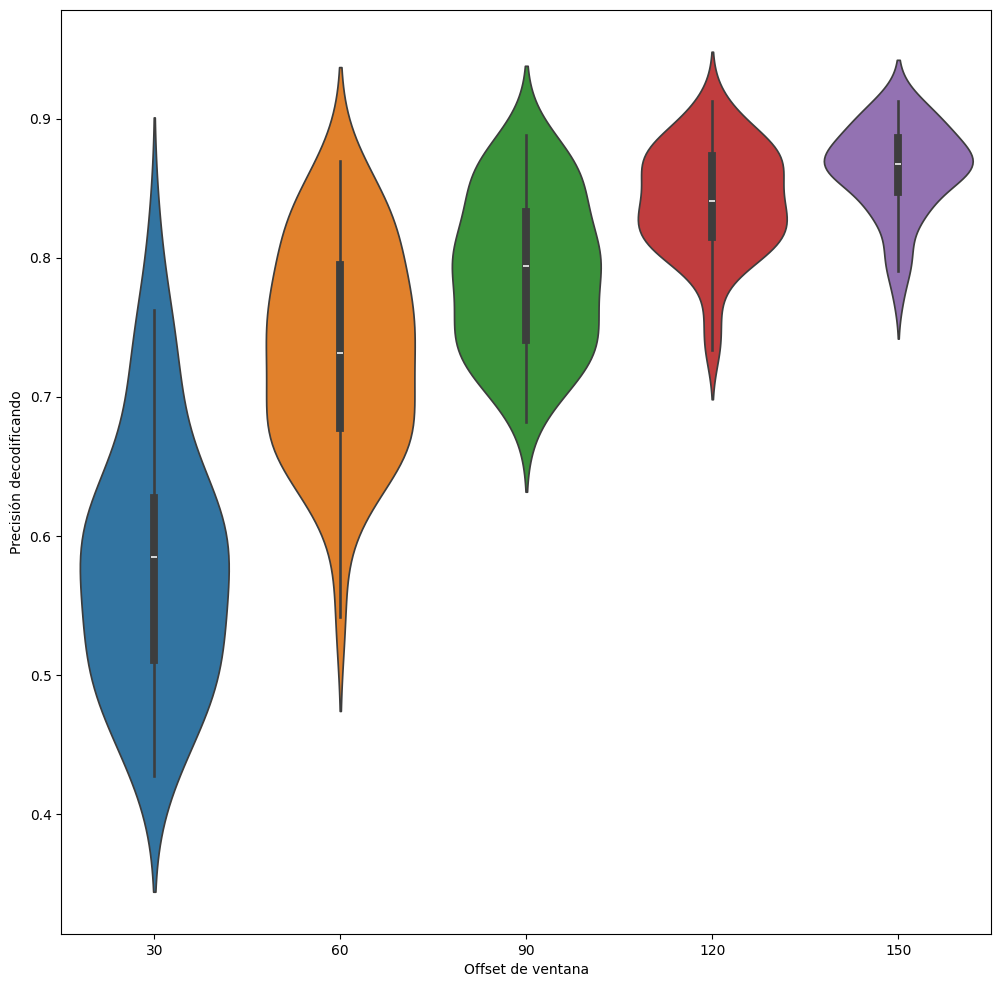

In [44]:
import pandas as pd
fig = plt.figure(figsize=(12,12))
ax = sns.violinplot(data=pd.DataFrame(decode_perf.T, columns=np.arange(30,180,30)))
#Para el que nunca haya visto Violinplots antes, son escencialmente histogramas que han sido suavizados y espejados para facilitar la visualización
ax.set(xlabel='Offset de ventana', ylabel='Precisión decodificando')
plt.show()